<a href="https://colab.research.google.com/github/msmccann10/Portfolio/blob/main/board-game-prediction/Board_Game_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Board Game Prediction
- **Author:** Michael McCann
- **Date:** 01 APR 2022

## Imports

In [1]:
## Import Libraries
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from lightgbm import LGBMRegressor, LGBMClassifier
from xgboost import XGBRegressor, XGBClassifier
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor ,BaggingClassifier, RandomForestClassifier
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import classification_report, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, RocCurveDisplay
from sklearn import set_config
set_config(display='diagram')

## Functions

### OHE Reversing Function

In [2]:
## create OHE reversing function...
def ohe_reverse(row, names):
    # Change the row into a np.array
    cat = np.array(row) 
    # Add spaces and commas into the name array for spacing..
    names = [' ' + i + ',' for i in names]
    return ''.join(np.repeat(names, cat))

### Custom Make Longer Function

In [3]:
## Create A custome longer function...
def make_longer(data, col):
    # fix output - blanks
    bad_rows = data[data['ohe'] == ''].index
    data.drop(bad_rows, inplace = True)

    data['ohe'] = data['ohe'].str.lstrip()
    data['ohe'] = data['ohe'].str[:-1]

    # Stack the result 
    val = pd.concat([data['BGGId'],
                data['ohe'].str.split(',', expand = True)],
                axis = 1)

    melt = pd.melt(val, id_vars=['BGGId'])
    long_df = melt[melt.value.notnull()].sort_values('BGGId').reset_index(drop=True).rename(columns={'value':col}).drop(columns = 'variable')
    long_df[col] = long_df[col].str.lstrip()
    data.drop(columns = 'ohe', inplace = True)
    return long_df

### Distribution Graphing Function

In [4]:
## Create Functions for graphing Distribution of major features:
# Feature Distribution Graphs
def feature_dist(data, col, topX = 20, binW = 10):

    values = data[col].value_counts()

    fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (14,7))
    sns.barplot(x = values.head(topX),y = values.head(topX).index, color = 'Green', ax = axes[0])
    axes[0].set_xlabel('Number of Games', weight = 'semibold', fontsize = 14)
    axes[0].set_ylabel(f'{col}s', weight = 'semibold', fontsize = 14)
    axes[0].set_title(f'Most Prolific {col}s (Top {topX})', weight = 'semibold', fontsize = 16)
    axes[0].set_axisbelow(True)
    axes[0].grid(alpha = .4)
    sns.histplot(values, binwidth=binW, binrange=(0,150), color = '#127ead', ax=axes[1])
    axes[1].set_xlim(0,150)
    axes[1].set_xlabel(f'Number of Games (bin width = {binW})', weight = 'semibold', fontsize = 14)
    axes[1].set_ylabel(f'{col}s per Bin', weight = 'semibold', fontsize = 14)
    axes[1].set_title(f"{col}s Distribution", weight = 'semibold', fontsize = 16)
    axes[1].set_axisbelow(True)
    plt.grid(alpha = .4)
    plt.tight_layout()
    plt.show();

# Feature Distribution Graphs 2
def feature_dist2(data, col, topX = 20):
    values = data[col].value_counts()

    fig, ax = plt.subplots(figsize = (18,6))   
    sns.barplot(y = values.head(topX),x = values.head(topX).index, color = '#A90200', alpha = .9)
    plt.xlabel(f'{col}s (Top {topX})', weight = 'semibold', fontsize = 14)
    plt.ylabel('Number of Games', weight = 'semibold', fontsize = 14)
    plt.title(f"Top {col}s", weight = 'semibold', fontsize = 18)
    ax.set_axisbelow(True)
    plt.grid(alpha = .4)
    plt.xticks(rotation=60, ha = "right", rotation_mode = 'anchor')
    plt.tight_layout()
    plt.show();

### Top/Bottom Split Function

In [5]:
## Create Function to Split artist/designer/producers by top/bottom percent:
def topbot_split(data, data5k, col, top_col = 'top', bot_col = 'bot', split_perc = 20,):
    temp = pd.merge(data, bggid, how = 'right', on = 'BGGId')
    temp.fillna(value = 0, inplace = True)

    # denominator for split value for loop (below)
    denom = data5k[col].value_counts().sum()
    head_val = 0

    # find split value
    for i in range(0,50):
        if math.floor(data5k[col].value_counts().head(i).sum()/denom * 100) == split_perc:
            head_val = i
            break
            
    # Use above value to create mask
    mask =list(data5k[col].value_counts().head(head_val).index)

    # Apply to the ohe DF
    temp_top = temp[mask] #create a top 20% df
    temp_bot = temp.drop(columns = mask)#create a bottom 20% df

    temp_top[top_col] = temp_top.max(axis = 1)
    temp_bot[bot_col] = temp_bot.drop(columns = 'BGGId').max(axis = 1)
    temp_topbot = pd.concat([temp_bot['BGGId'], temp_top[top_col], temp_bot[bot_col]], axis = 1)
    return temp_topbot

### Model Performance Function - Regression

In [6]:
regressperformance = pd.DataFrame(columns = ['model name', 'R-Squared (R2)',
                                           'Mean Absolute Error (MAE)', 
                                           'Mean Squared Error (MSE)', 
                                           'Root Mean Squared Error (RMSE)'])

## Create Function to evaluate regression models
from numpy.ma.core import sqrt
def model_eval(model, model_name, X_train, X_test, y_train, y_test):
    # Get Preds
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)

    # Get Metrics
    r2_train = round(r2_score(y_train, train_preds), 3)
    r2_test = round(r2_score(y_test, test_preds), 3)
    mae_train = round(mean_absolute_error(y_train, train_preds), 3)
    mae_test = round(mean_absolute_error(y_test, test_preds), 3)
    mse_train = round(mean_squared_error(y_train, train_preds), 3)
    mse_test = round(mean_squared_error(y_test, test_preds), 3)
    rmse_train = round(np.sqrt(mean_squared_error(y_train, train_preds)), 3)
    rmse_test = round(np.sqrt(mean_squared_error(y_test, test_preds)), 3)

    # Save into Display
    temp_df = pd.DataFrame({'model': [model_name, model_name], 'Type': ['Training', 'Testing'],
                            'R2': [r2_train, r2_test], 'MAE': [mae_train, mae_test],
                            'MSE': [mse_train, mse_test], 'RMSE': [rmse_train, rmse_test]})

    display(temp_df)

    metrics = {'model name': model_name, 'R-Squared (R2)': r2_test, 
               'Mean Absolute Error (MAE)': mae_test, 
               'Mean Squared Error (MSE)': mse_test, 
               'Root Mean Squared Error (RMSE)': rmse_test}

    return metrics

### Model Performance Function - Classification

In [7]:
classperformance = pd.DataFrame(columns = ['model name', 'accuracy', 'roc_auc', 
                                           'precision_min', 'recall_min', 'f1-score_min', 
                                           'precision_maj', 'recall_maj', 'f1-score_maj'])

def class_eval(model, model_name, X_train, X_test, y_train, y_test):
    # Get Preds
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)

    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)

    print(classification_report(y_test, test_preds))

    fig, ax = plt.subplots(ncols=2, nrows = 1, figsize=(10,6))
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='Blues',
                                          ax=ax[0])
    
    
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='Blues',
                                          normalize='true', ax=ax[1])
    
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
    clf_rep = precision_recall_fscore_support(y_test, test_preds)
    metrics = {'model name': model_name, 'accuracy': test_score, 'roc_auc': roc_auc,
               'precision_min': clf_rep[0][1], 'recall_min': clf_rep[1][1], 
               'f1-score_min': clf_rep[2][1], 'precision_maj': clf_rep[0][0], 
               'recall_maj': clf_rep[1][0], 'f1-score_maj': clf_rep[2][0]}

    return metrics

# Data Cleaning
The data for this project comes from multiple separate dataframes so I will work through these one at a time prior to merging them into a larger dataframe for ML.

## Rank DF

In [8]:
# Import Data
rank_df = pd.read_csv('https://raw.githubusercontent.com/msmccann10/Portfolio/main/board-game-prediction/data/Rankings/rankings%20by%20id.csv')
rank_df.head()

,BoardGameRank,2018-10-06,2018-10-13,2018-10-20,2018-10-27,2018-11-03,2018-11-09,2018-11-17,2018-11-24,2018-12-01,...,2022-01-08,2022-01-15,2022-01-22,2022-01-29,2022-02-05,2022-02-12,2022-02-19,2022-02-26,2022-03-05,2022-03-12
0,1,174430.0,174430.0,174430.0,174430.0,174430.0,174430.0,174430.0,174430.0,174430.0,...,174430.0,174430.0,174430.0,174430.0,174430.0,174430.0,174430.0,174430.0,174430.0,174430.0
1,2,161936.0,161936.0,161936.0,161936.0,161936.0,161936.0,161936.0,161936.0,161936.0,...,161936.0,161936.0,161936.0,161936.0,161936.0,161936.0,161936.0,161936.0,161936.0,161936.0
2,3,182028.0,182028.0,182028.0,182028.0,182028.0,182028.0,182028.0,182028.0,182028.0,...,224517.0,224517.0,224517.0,224517.0,224517.0,224517.0,224517.0,224517.0,224517.0,224517.0
3,4,167791.0,167791.0,167791.0,167791.0,167791.0,167791.0,167791.0,167791.0,167791.0,...,167791.0,167791.0,167791.0,167791.0,167791.0,167791.0,167791.0,167791.0,167791.0,167791.0
4,5,12333.0,12333.0,12333.0,12333.0,12333.0,12333.0,12333.0,12333.0,12333.0,...,233078.0,233078.0,233078.0,233078.0,291457.0,233078.0,291457.0,291457.0,291457.0,291457.0


Dataset Creator claims to have increased the numbers of ranks scraped from 2000 to 5000 starting September 7, 2019. The below code confirms an increase, however, similar to previous dates the number is actually less than the intended 5000. 


In [9]:
# Confirm point at which the pull increases.
print(f'Number of non-null values on August 31, 2019: {5015 - (rank_df["2019-08-31"].isna().sum())} ')
print(f'Number of non-null values on September 07, 2019: {5015 - (rank_df["2019-09-07"].isna().sum())} ')
print(f'Number of non-null values on September 14, 2019: {5015 - (rank_df["2019-09-14"].isna().sum())} \n\n')

# Get the index for the 2019-09-07
print(f'Column index for September 07, 2019: {rank_df.columns.get_loc("2019-09-07")}')

Number of non-null values on August 31, 2019: 1997 
Number of non-null values on September 07, 2019: 4982 
Number of non-null values on September 14, 2019: 4981 


Column index for September 07, 2019: 49


In [10]:
# Drop columns from before September 7, 2019.
rank_df.drop(rank_df.columns[1:49], axis = 1, inplace = True)
rank_df

,BoardGameRank,2019-09-07,2019-09-14,2019-09-21,2019-09-28,2019-10-05,2019-10-12,2019-10-19,2019-10-26,2019-11-02,...,2022-01-08,2022-01-15,2022-01-22,2022-01-29,2022-02-05,2022-02-12,2022-02-19,2022-02-26,2022-03-05,2022-03-12
0,1,174430.0,174430.0,174430.0,174430.0,174430.0,174430.0,174430.0,174430.0,174430.0,...,174430.0,174430.0,174430.0,174430.0,174430.0,174430.0,174430.0,174430.0,174430.0,174430.0
1,2,161936.0,161936.0,161936.0,161936.0,161936.0,161936.0,161936.0,161936.0,161936.0,...,161936.0,161936.0,161936.0,161936.0,161936.0,161936.0,161936.0,161936.0,161936.0,161936.0
2,3,167791.0,167791.0,167791.0,167791.0,167791.0,167791.0,167791.0,167791.0,167791.0,...,224517.0,224517.0,224517.0,224517.0,224517.0,224517.0,224517.0,224517.0,224517.0,224517.0
3,4,182028.0,182028.0,182028.0,182028.0,182028.0,182028.0,182028.0,182028.0,182028.0,...,167791.0,167791.0,167791.0,167791.0,167791.0,167791.0,167791.0,167791.0,167791.0,167791.0
4,5,12333.0,12333.0,12333.0,12333.0,12333.0,12333.0,12333.0,12333.0,12333.0,...,233078.0,233078.0,233078.0,233078.0,291457.0,233078.0,291457.0,291457.0,291457.0,291457.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5010,5009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5011,5007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5012,5023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5013,5021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# Drop odd columns 5002+ which are just full of NA values...
rank_df = rank_df.head(5002)
rank_df.isna().sum().sort_values(ascending = False)

2020-01-04       38
2020-12-26       36
2020-02-08       32
2020-01-18       25
2020-08-08       25
                 ..
2021-07-03        2
2021-06-27        2
2021-02-20        2
2021-05-01        2
BoardGameRank     0
Length: 132, dtype: int64

In [12]:
# NAs arent only appearing at the tail end of the numbers... they are interspersed within the dataset.
rank_df.tail()

,BoardGameRank,2019-09-07,2019-09-14,2019-09-21,2019-09-28,2019-10-05,2019-10-12,2019-10-19,2019-10-26,2019-11-02,...,2022-01-08,2022-01-15,2022-01-22,2022-01-29,2022-02-05,2022-02-12,2022-02-19,2022-02-26,2022-03-05,2022-03-12
4997,4601,NaN,5635.0,8316.0,17526.0,NaN,637.0,95386.0,5233.0,267378.0,...,191989.0,748.0,333539.0,240465.0,197178.0,165877.0,180543.0,132497.0,30328.0,172994.0
4998,4607,NaN,218126.0,5635.0,267735.0,103670.0,216179.0,145.0,6191.0,35634.0,...,206805.0,118023.0,3597.0,6137.0,43320.0,178147.0,244794.0,244794.0,34.0,97875.0
4999,4801,NaN,5251.0,181404.0,10623.0,138614.0,121993.0,181404.0,NaN,3852.0,...,126613.0,132817.0,4753.0,207330.0,93541.0,1942.0,158544.0,114991.0,231748.0,247106.0
5000,4976,NaN,68188.0,94731.0,244994.0,76207.0,62030.0,192906.0,202942.0,1533.0,...,308621.0,3040.0,163097.0,317981.0,225214.0,222821.0,16320.0,222821.0,7103.0,189294.0
5001,5001,NaN,NaN,NaN,231450.0,NaN,NaN,128011.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,37672.0,NaN,NaN,NaN,NaN


In [13]:
# Create pd.Series of all values in columns
game_list = list(rank_df[rank_df.columns[2]])
for col in rank_df.columns[2:]:
    game_list += list(rank_df[col])

game_list = pd.Series(game_list)
game_list.drop_duplicates(inplace = True)
game_list

# Create a new DF using the above Series
new_df = pd.DataFrame(game_list, columns = ['BGGId'] )
new_df.reset_index(inplace = True, drop = True)

# Create a blank dictionary to iterate through the above series
game_dict = {}
for i in list(game_list)[0:len(game_list)]:
    game_dict.update({i : np.nan}) 

for i in rank_df.columns[1:]:
    temp_dict = dict(zip(rank_df[i], rank_df['BoardGameRank']))
    game_dict.update(temp_dict)
    new_df[i] = new_df['BGGId'].copy()
    # new_df.reset_index(drop = True, inplace = True)
    new_df[i] = new_df[i].replace(game_dict)
    game_dict = {}
    for i in list(game_list)[0:len(game_list)]:
        game_dict.update({i : np.nan}) 

new_df.head(10)

# Fill NA with a dummy value of 999999
# rank_df.fillna(value = 999999, inplace = True)
# rank_df.tail()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


,BGGId,2019-09-07,2019-09-14,2019-09-21,2019-09-28,2019-10-05,2019-10-12,2019-10-19,2019-10-26,2019-11-02,...,2022-01-08,2022-01-15,2022-01-22,2022-01-29,2022-02-05,2022-02-12,2022-02-19,2022-02-26,2022-03-05,2022-03-12
0,174430.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,161936.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
2,167791.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
3,182028.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,...,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,10.0,10.0
4,12333.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,13.0,13.0,13.0,13.0,13.0,13.0,13.0,13.0,13.0,13.0
5,187645.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,...,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0
6,233078.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,...,5.0,5.0,5.0,5.0,6.0,5.0,6.0,6.0,6.0,6.0
7,220308.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,...,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0
8,169786.0,9.0,9.0,9.0,9.0,9.0,9.0,10.0,10.0,10.0,...,14.0,14.0,14.0,14.0,14.0,14.0,14.0,14.0,14.0,14.0
9,193738.0,10.0,10.0,10.0,10.0,10.0,11.0,11.0,11.0,11.0,...,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0


In [14]:
# Test on #1 Game: Gloomhaven (BGG ID: 174430)
new_df[new_df['BGGId'] == 174430.0]

,BGGId,2019-09-07,2019-09-14,2019-09-21,2019-09-28,2019-10-05,2019-10-12,2019-10-19,2019-10-26,2019-11-02,...,2022-01-08,2022-01-15,2022-01-22,2022-01-29,2022-02-05,2022-02-12,2022-02-19,2022-02-26,2022-03-05,2022-03-12
0,174430.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [15]:
# Eliminate single NA value in our ID column...
na_index = new_df[new_df['BGGId'].isna()].index
new_df.drop(na_index, inplace = True)

# Convert ID column to int64 for later merger with other data
new_df['BGGId'] = new_df['BGGId'].astype('int')

new_df['num_times'] = new_df[new_df.columns[1:132]].count(axis=1)
new_df['avg_rank'] = round(new_df[new_df.columns[1:132]].mean(axis=1), 1)

# Create a column to indicate the game cracked the top 100 at some point since SEP 2019
new_df['Top_100'] = new_df[new_df.columns[1:132]].min(axis = 1) <= 100

# Create a column to indicate the game cracked the top 20 at some point since SEP 2019
new_df['Top_20'] = new_df[new_df.columns[1:132]].min(axis = 1) <= 20

rank_df = new_df
rank_df.head()

,BGGId,2019-09-07,2019-09-14,2019-09-21,2019-09-28,2019-10-05,2019-10-12,2019-10-19,2019-10-26,2019-11-02,...,2022-02-05,2022-02-12,2022-02-19,2022-02-26,2022-03-05,2022-03-12,num_times,avg_rank,Top_100,Top_20
0,174430,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,131,1.0,True,True
1,161936,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,131,2.0,True,True
2,167791,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,...,4.0,4.0,4.0,4.0,4.0,4.0,131,3.7,True,True
3,182028,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,...,9.0,9.0,9.0,9.0,10.0,10.0,131,6.4,True,True
4,12333,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,13.0,13.0,13.0,13.0,13.0,13.0,131,9.5,True,True


In [16]:
bggid = rank_df['BGGId']
bggid20 = rank_df[rank_df['Top_20'] == True]['BGGId']
bggid100 = rank_df[rank_df['Top_100'] == True]['BGGId']
bggid1k = rank_df[rank_df[rank_df.columns[1:132]].min(axis = 1) <= 1000]['BGGId']

## Game DF

In [17]:
## Import Files
game_df = pd.read_csv('https://github.com/msmccann10/Portfolio/raw/main/board-game-prediction/data/Rankings/rankings%20reference.csv')
game_df.head()

,game_id,name,boardgamedesigner,boardgameartist,yearpublished,minplayers,maxplayers,minage,playingtime,minplaytime,...,StrategyGameRank_max_date,ThematicRank_min,ThematicRank_min_date,ThematicRank_max,ThematicRank_max_date,WarGameRank_min,WarGameRank_min_date,WarGameRank_max,WarGameRank_max_date,bgg_url
0,174430,Gloomhaven,['Isaac Childres'],"['Alexandr Elichev', 'Josh T. McDowell', 'Alva...",2017,1,4,14,120,60,...,2018-10-06,1.0,2018-10-06,1.0,2018-10-06,NaN,NaN,NaN,NaN,https://boardgamegeek.com/boardgame/174430
1,161936,Pandemic Legacy: Season 1,"['Rob Daviau', 'Matt Leacock']",['Chris Quilliams'],2015,2,4,13,60,60,...,2021-06-05,2.0,2018-10-06,2.0,2018-10-06,NaN,NaN,NaN,NaN,https://boardgamegeek.com/boardgame/161936
2,224517,Brass: Birmingham,"['Gavan Brown', 'Matt Tolman', 'Martin Wallace']","['Lina Cossette', 'David Forest', 'Damien Mamm...",2018,2,4,14,120,60,...,2018-10-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://boardgamegeek.com/boardgame/224517
3,167791,Terraforming Mars,['Jacob Fryxelius'],['Isaac Fryxelius'],2016,1,5,12,120,120,...,2021-04-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://boardgamegeek.com/boardgame/167791
4,291457,Gloomhaven: Jaws of the Lion,['Isaac Childres'],"['Francesca Baerald', 'David Demaret', 'Alexan...",2020,1,4,14,120,30,...,2020-06-27,3.0,2021-02-27,17.0,2020-09-05,NaN,NaN,NaN,NaN,https://boardgamegeek.com/boardgame/291457


In [18]:
game_df.rename(columns={'game_id':'BGGId'}, inplace = True)
game_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4998 entries, 0 to 4997
Data columns (total 53 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   BGGId                       4998 non-null   int64  
 1   name                        4998 non-null   object 
 2   boardgamedesigner           4998 non-null   object 
 3   boardgameartist             4998 non-null   object 
 4   yearpublished               4998 non-null   int64  
 5   minplayers                  4998 non-null   int64  
 6   maxplayers                  4998 non-null   int64  
 7   minage                      4998 non-null   int64  
 8   playingtime                 4998 non-null   int64  
 9   minplaytime                 4998 non-null   int64  
 10  maxplaytime                 4998 non-null   int64  
 11  boardgamepublisher          4998 non-null   object 
 12  boardgamecategory           4998 non-null   object 
 13  boardgamefamily             4998 

In [19]:
# Get rid of the individual mechanic scores
game_df.drop(game_df.columns[24:], axis = 1, inplace = True)
game_df.drop(game_df.columns[15:19], axis = 1, inplace = True)

In [20]:
game_df.isna().sum()

BGGId                     0
name                      0
boardgamedesigner         0
boardgameartist           0
yearpublished             0
minplayers                0
maxplayers                0
minage                    0
playingtime               0
minplaytime               0
maxplaytime               0
boardgamepublisher        0
boardgamecategory         0
boardgamefamily           0
boardgamemechanic         0
first_date_in_ref         0
BoardGameRank_min         0
BoardGameRank_min_date    0
BoardGameRank_max         0
BoardGameRank_max_date    0
dtype: int64

## Designer DF

In [21]:
# Load Designer Data
design_df = pd.read_csv('https://github.com/msmccann10/Portfolio/raw/main/board-game-prediction/data/game%20info/designers_reduced.csv')#, index_col = 'BGGId')

design_df.columns = design_df.columns.str.replace(r'[^\w\s]+', '')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  after removing the cwd from sys.path.


In [22]:
# Run ohe_reverse function
design_df['ohe'] = design_df.drop('BGGId', axis=1).apply(lambda row: ohe_reverse(row, list(row.index)), axis = 1) 

# Run make_longer
design_long = make_longer(design_df, 'Designer')

design_long.head(10)

,BGGId,Designer
0,1,KarlHeinz Schmiel
1,2,G W Jerry DArcey
2,3,Reiner Knizia
3,4,LowExp Designer
4,5,Sid Sackson
5,6,Jean du Poël
6,7,LowExp Designer
7,8,Martin Wallace
8,9,Wolfgang Kramer
9,9,Richard Ulrich


### Designer Graph

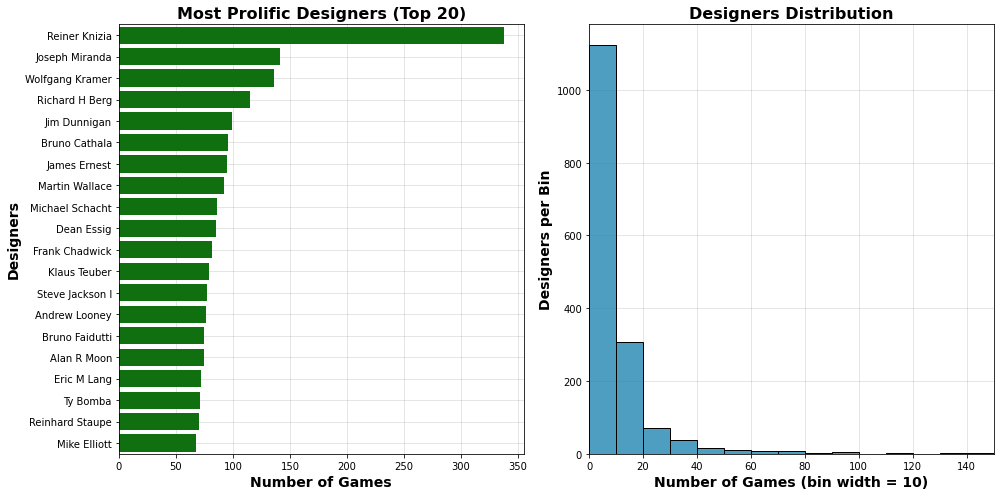

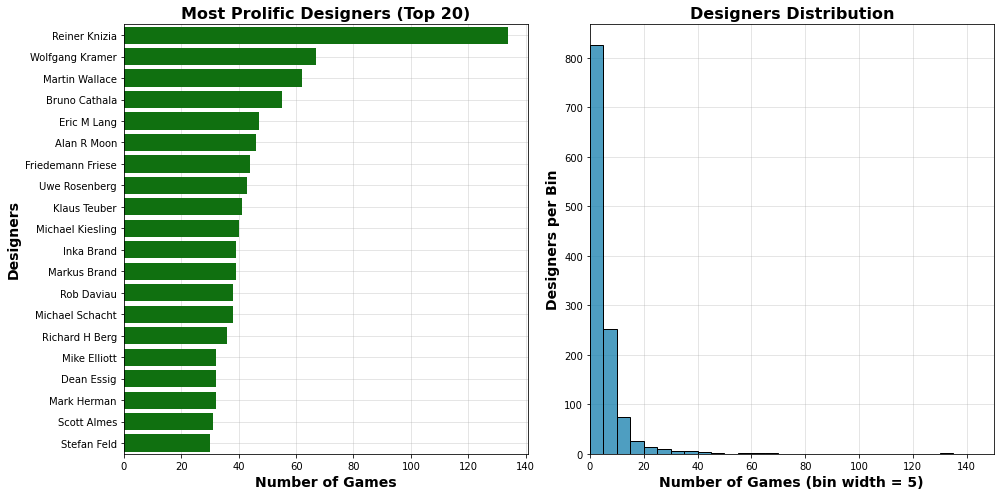

In [23]:
bad_rows = design_long[(design_long['Designer'] == 'LowExp Designer') | (design_long['Designer'] == 'Uncredited') ].index
# design_long.drop(bad_rows, inplace = True)

# Run Feature Distribution
feature_dist(design_long.drop(bad_rows), 'Designer', 20, 10)

design5k = pd.merge(design_long, bggid, how = 'right', on = 'BGGId')
bad_rows = design5k[(design5k['Designer'] == 'LowExp Designer') | (design5k['Designer'] == 'Uncredited') ].index

feature_dist(design5k.drop(bad_rows), 'Designer', 20, 5)

### Designer Top/Bottom Split (DF = design_topbot)

In [24]:
# Get rid of floating 'Jr.'
jr_index = design5k[design5k['Designer'] == 'Jr.'].index
design5k.drop(jr_index, inplace = True)

design_topbot = topbot_split(design_df, design5k, 'Designer', 'top_design', 'bot_design', 20)
design_topbot

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,BGGId,top_design,bot_design
0,174430,NaN,1.0
1,161936,NaN,1.0
2,167791,NaN,1.0
3,182028,NaN,1.0
4,12333,NaN,1.0
...,...,...,...
5926,322589,NaN,0.0
5927,305752,NaN,1.0
5928,315610,NaN,0.0
5929,280501,NaN,1.0


## Artist DF

In [25]:
# Load Designer Data
artist_df = pd.read_csv('https://github.com/msmccann10/Portfolio/raw/main/board-game-prediction/data/game%20info/artists_reduced.csv')
artist_df.columns = artist_df.columns.str.replace(r'[^\w\s]+', '')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


In [26]:
# Run ohe_reverse function
artist_df['ohe'] = artist_df.drop('BGGId', axis=1).apply(lambda row: ohe_reverse(row, list(row.index)), axis = 1) 

# Run make_longer
artist_long = make_longer(artist_df, 'Artist')
avg_num_artist = pd.merge(artist_long, bggid, how = 'right', on = 'BGGId').groupby('BGGId')['Artist'].nunique().mean()

artist_long.head(10)

,BGGId,Artist
0,1,Harald Lieske
1,1,LowExp Artist
2,2,LowExp Artist
3,3,Franz Vohwinkel
4,4,LowExp Artist
5,5,Scott Okumura
6,5,Peter Whitley
7,6,LowExp Artist
8,7,Uncredited
9,7,LowExp Artist


### Artist Graph

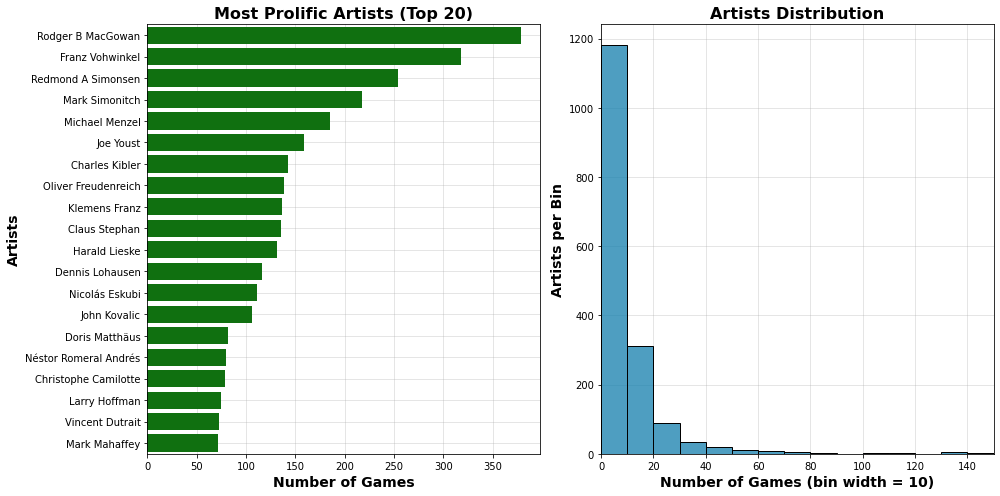

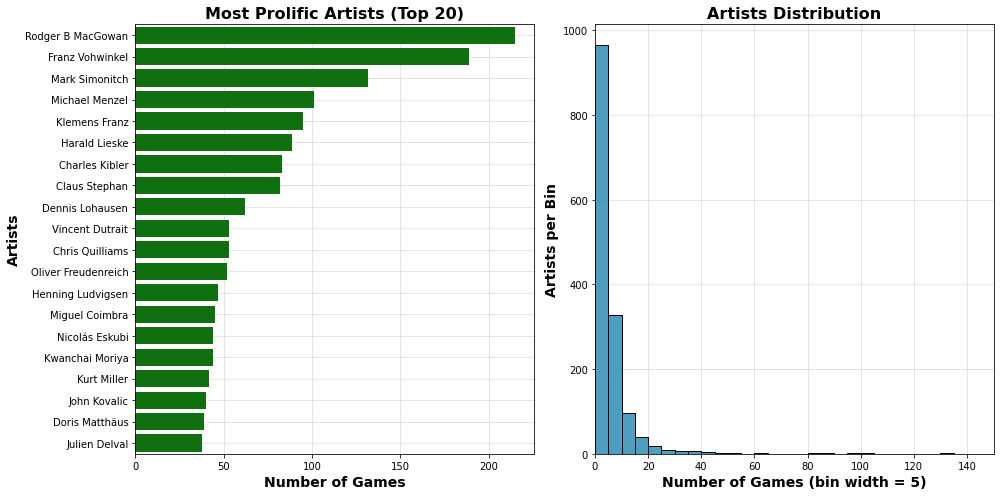

In [27]:
# Rows to remove before graphing...
bad_rows = artist_long[(artist_long['Artist'] == 'LowExp Artist') | (artist_long['Artist'] == 'Uncredited') ].index

# Run Feature Distribution
feature_dist(artist_long.drop(bad_rows), 'Artist', 20, 10)

artist5k = pd.merge(artist_long, bggid, how = 'right', on = 'BGGId')
bad_rows = artist5k[(artist5k['Artist'] == 'LowExp Artist') | (artist5k['Artist'] == 'Uncredited') ].index

feature_dist(artist5k.drop(bad_rows), 'Artist', 20, 5)

### Artist Top/Bottom Split (DF = artist_topbot)

In [28]:
# Split games by top and bottom artists
artist_topbot = topbot_split(artist_df, artist5k, 'Artist', 'top_artist', 'bot_artist', 20)
artist_topbot

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,BGGId,top_artist,bot_artist
0,174430,NaN,1.0
1,161936,NaN,1.0
2,167791,NaN,1.0
3,182028,NaN,1.0
4,12333,NaN,1.0
...,...,...,...
5926,322589,NaN,0.0
5927,305752,NaN,1.0
5928,315610,NaN,0.0
5929,280501,NaN,1.0


## Publisher DF

In [29]:
# Load in the Publisher Data
publish_df = pd.read_csv('https://github.com/msmccann10/Portfolio/raw/main/board-game-prediction/data/game%20info/publishers_reduced.csv')#, index_col = 'BGGId' )

# Many column names include .LTD or other punctuation that makes this complicated.
# Use str.replace to remove unwanted punctuation
publish_df.columns = publish_df.columns.str.replace(r'[^\w\s]+', '')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [ ]:
# Run ohe_reverse function
publish_df['ohe'] = publish_df.drop('BGGId', axis=1).apply(lambda row: ohe_reverse(row, list(row.index)), axis = 1) 

# Run make_longer
publish_long = make_longer(publish_df, 'Publisher')
avg_num_publish = pd.merge(publish_long, bggid, how = 'right', on = 'BGGId').groupby('BGGId')['Publisher'].nunique().mean()

publish_long.head(10)

### Publisher Graph

In [ ]:
bad_rows = publish_long[(publish_long['Publisher'] == 'LowExp Publisher') |
                        (publish_long['Publisher'] == 'SelfPublished') |
                        (publish_long['Publisher'] == 'Web published')].index
# publish_long.drop(bad_rows, inplace = True)

# Run Feature Distribution
feature_dist(publish_long.drop(bad_rows), 'Publisher', 20, 10)

publish5k = pd.merge(publish_long, bggid, how = 'right', on = 'BGGId')
bad_rows = publish5k[(publish5k['Publisher'] == 'LowExp Publisher') |
                        (publish5k['Publisher'] == 'SelfPublished') |
                        (publish5k['Publisher'] == 'Web published')].index

feature_dist(publish5k.drop(bad_rows), 'Publisher', 20, 5)

### Publisher Top/Bottom Split (DF = publish_topbot)

In [ ]:
# KeyError: "['Korea Boardgames Co.', 'Swan Panasia Co.'] not in index"
# list(publish_df.columns.sort_values())
# publish5k[publish5k['Publisher'] == 'Swan Panasia Co.']
publish_topbot = topbot_split(publish_df, publish5k, 'Publisher', 'top_publish', 'bot_publish', 20)
publish_topbot

## Mechanics DF

In [ ]:
# Load Mechanics Data
mech_df = pd.read_csv('https://github.com/msmccann10/Portfolio/raw/main/board-game-prediction/data/game%20info/mechanics.csv')#, index_col = 'BGGId' )

# Rename Columns that contain commas
mech_df = mech_df.rename(columns={'I Cut, You Choose':'I Cut You Choose', 'Deck, Bag, and Pool Building': 'Deck / Bag / Pool Building'})

In [ ]:
# Run ohe_reverse function
mech_df['ohe'] = mech_df.drop('BGGId', axis=1).apply(lambda row: ohe_reverse(row, list(row.index)), axis = 1) 

# Run make_longer
mech_long = make_longer(mech_df, 'Mechanic')
avg_num_mech = pd.merge(mech_long, bggid, how = 'right', on = 'BGGId').groupby('BGGId')['Mechanic'].nunique().mean()

mech_long.head(10)

In [ ]:
# Run Feature Distribution
feature_dist2(mech_long, 'Mechanic', 20)

mech5k = pd.merge(mech_long, bggid, how = 'right', on = 'BGGId')

feature_dist2(mech5k, 'Mechanic', 20)

## Sub-Categories DF

In [ ]:
# Load in Subcategories
subcat_df = pd.read_csv('https://github.com/msmccann10/Portfolio/raw/main/board-game-prediction/data/game%20info/subcategories.csv')#, index_col = 'BGGId' )


In [ ]:
# Run ohe_reverse function
subcat_df['ohe'] = subcat_df.drop('BGGId', axis=1).apply(lambda row: ohe_reverse(row, list(row.index)), axis = 1) 

# Run make_longer
subcat_long = make_longer(subcat_df, 'Subcat')
avg_num_subcat = pd.merge(subcat_long, bggid, how = 'right', on = 'BGGId').groupby('BGGId')['Subcat'].nunique().mean()

subcat_long.head(10)

In [ ]:
feature_dist2(subcat_long, 'Subcat', 40)

subcat5k = pd.merge(subcat_long, bggid, how = 'right', on = 'BGGId')

feature_dist2(subcat5k, 'Subcat', 20)

## Themes DF

In [ ]:
theme_df = pd.read_csv('https://github.com/msmccann10/Portfolio/raw/main/board-game-prediction/data/game%20info/themes.csv')#, index_col = 'BGGId' )

theme_df.columns = theme_df.columns.str.replace(r'[^\w\s]+', '')

In [ ]:
# Run ohe_reverse function
theme_df['ohe'] = theme_df.drop('BGGId', axis=1).apply(lambda row: ohe_reverse(row, list(row.index)), axis = 1) 

# Run make_longer
theme_long = make_longer(theme_df, 'Theme')
avg_num_theme = pd.merge(theme_long, bggid, how = 'right', on = 'BGGId').groupby('BGGId')['Theme'].nunique().mean()

theme_long.head(10)

In [ ]:
feature_dist2(theme_long, 'Theme', 20)

theme5k = pd.merge(theme_long, bggid, how = 'right', on = 'BGGId')

feature_dist2(theme5k, 'Theme', 20)

# Average Game Stats by Category

In [ ]:
avg_num_design = pd.merge(design_long, bggid, how = 'right', on = 'BGGId').groupby('BGGId')['Designer'].nunique().mean()
avg_num_artist = pd.merge(artist_long, bggid, how = 'right', on = 'BGGId').groupby('BGGId')['Artist'].nunique().mean()
avg_num_publish = pd.merge(publish_long, bggid, how = 'right', on = 'BGGId').groupby('BGGId')['Publisher'].nunique().mean()
avg_num_mech = pd.merge(mech_long, bggid, how = 'right', on = 'BGGId').groupby('BGGId')['Mechanic'].nunique().mean()
avg_num_subcat = pd.merge(subcat_long, bggid, how = 'right', on = 'BGGId').groupby('BGGId')['Subcat'].nunique().mean()
avg_num_theme = pd.merge(theme_long, bggid, how = 'right', on = 'BGGId').groupby('BGGId')['Theme'].nunique().mean()

# avg_num_design = design5k.groupby('BGGId')['Designer'].nunique().mean()
# avg_num_artist = artist5k.groupby('BGGId')['Artist'].nunique().mean()
# avg_num_publish = publish5k.groupby('BGGId')['Publisher'].nunique().mean()
# avg_num_mech = mech5k.groupby('BGGId')['Mechanic'].nunique().mean()
# avg_num_subcat = subcat5k.groupby('BGGId')['Subcat'].nunique().mean()
# avg_num_theme = theme5k.groupby('BGGId')['Theme'].nunique().mean()

In [ ]:
# Average Game Statistics
print(f'Average Game Statistics (Top 5000)')
print(f'   Number of Designers: {avg_num_design:.2f}')
print(f'   Number of Artists: {avg_num_artist:.2f}')
print(f'   Number of Publishers: {avg_num_publish:.2f}')
print(f'   Number of Mechanics: {avg_num_mech:.2f}')
print(f'   Number of Sub-Categories: {avg_num_subcat:.2f}')
print(f'   Number of Themes: {avg_num_theme:.2f}')

## Games2 DF

In [ ]:
games2 = pd.read_csv('https://raw.githubusercontent.com/msmccann10/Portfolio/main/board-game-prediction/data/game%20info/games.csv')

In [ ]:
games2.head()

In [ ]:
games2.info()

In [ ]:
games2.drop(games2.iloc[:,30:40], inplace = True, axis = 1)
games2.drop(columns = ['Description', 'LanguageEase', 'StdDev', 'NumOwned',  'NumWant', 'NumWish', 'NumWeightVotes', 'NumComments'], inplace = True)
games2.info()

In [ ]:
games2_test2 = games2[games2['NumUserRatings'] >= 100]

In [ ]:
print('Number of 0 entries in each column')
for col in games2_test2.columns:
    num = games2_test2[games2_test2[col] == 0]['BGGId'].nunique()
    print(f'{col} has: {num}')

In [ ]:
games2_test = games2[(games2['NumUserRatings'] >= 100) & (games2['YearPublished'] != 0) & (games2['GameWeight'] != 0) 
& (games2['MinPlayers'] != 0) & (games2['MaxPlayers'] != 0) 
& (games2['ComMinPlaytime'] != 0) & (games2['ComMaxPlaytime'] != 0) 
& (games2['MfgAgeRec'] != 0) & (games2['MfgPlaytime'] != 0)]

In [ ]:
games2_test['BGGId'].nunique()

In [ ]:
games2_test['BestPlayers'].value_counts()

In [ ]:
#Unfortunately it looks like 'BestPlayer' must be included in the drop list as the info in the DF does not match with the info on BGG. A number of the 0's are innacurate. 
corr_drop = ['YearPublished', 'BGGId', 'NumAlternates', 'NumExpansions', 'NumImplementations', 'IsReimplementation', 'Kickstarted', 'MfgPlaytime', 'MfgAgeRec', 'MinPlayers', 'MaxPlayers', 'BestPlayers']
corr = round(games2_test.drop(columns = corr_drop).corr(), 2)
# corr = round(games2.drop(columns = corr_drop).corr(), 2)
# corr = round(corr.corr(), 2)

fig, ax = plt.subplots(figsize= (12,12))
sns.heatmap(corr, cmap = 'Reds', annot = True, ax = ax)
plt.title('Sales Data Correlation Matrix', fontsize = 16)
plt.xticks(rotation = 45, ha = "right", rotation_mode = 'anchor');

In [ ]:
plt.scatter(games2_test['AvgRating'], games2_test['GameWeight']);

In [ ]:
fig, ax = plt.subplots(figsize = (10, 10))
plt.scatter(games2_test['AvgRating'], games2_test['BayesAvgRating'], cmap = 'OrRd', c = games2_test['NumUserRatings'], alpha = 1);
plt.colorbar();
plt.xlabel('Average Rating', fontsize = 16, weight = 'semibold')
plt.ylabel('Bayes Average Rating', fontsize = 16, weight = 'semibold');

In [ ]:
fig, ax = plt.subplots(figsize = (10, 10))
plt.scatter(games2_test['NumUserRatings'], games2_test['BayesAvgRating']);
plt.xlabel('Number of User Ratings', fontsize = 16, weight = 'semibold')
plt.ylabel('Bayes Average Rating', fontsize = 16, weight = 'semibold');

# Merge Main

In [ ]:
# Merge the rank and the initial game DF..
main_df = pd.merge(game_df, rank_df, how = 'right', on = 'BGGId')

# Lose rows that are duplicated in the other DF..
main_df.drop(main_df.columns[2:20], axis = 1, inplace = True)

In [ ]:
df_list = [mech_df, subcat_df, theme_df]#, design_topbot, artist_topbot, publish_topbot]# , design_df, artist_df, publish_df]

main2_df = games2
for df in df_list:
    main2_df = pd.merge(main2_df, df, how = 'left', on = 'BGGId')
    # main2_df = main2_df.drop(columns = ['ohe'])

main2_df.drop(columns = 'Name', inplace = True)
main2_df.fillna(value = 0, inplace = True)

In [ ]:
merge_main = pd.merge(main_df, main2_df, how = 'inner', on = "BGGId")
merge_main.reset_index(inplace = True, drop = True)
merge_main

# Machine Learning - Linear Regression
Attempt to model avgrank

## Preprocessing

Identify Features

In [ ]:
# Bring in a copy to work with
merge_ml = merge_main.copy()

In [ ]:
## Feature Selection and 
# Drop date columns
merge_ml.drop(merge_ml.columns[2:133], axis = 1, inplace = True)

# Drop unique columns (ID, name)
merge_ml.drop(columns = ['BGGId', 'name'], inplace = True) 
                         
# Drop columns used for EDA that might have spill over (avg_rank, num_times, topx)
merge_ml.drop(columns = ['num_times', 'avg_rank', 'Top_100', 'Top_20'], inplace = True)

# While interesting best and good players have ~4000 entries with 0's so this feature will not be particularly useful for our analysis.
merge_ml.drop(columns = ['BestPlayers', 'GoodPlayers', 'Family'], inplace = True)

merge_ml.drop(columns = ['NumUserRatings', 'NumAlternates', 'NumExpansions', 'NumImplementations', 'IsReimplementation'], inplace=True)

# Drop Community Stats as we want to know what the Manucaturer can do to increase sales/ranking. 
merge_ml.drop(columns = ['ComAgeRec', 'ComMinPlaytime', 'ComMaxPlaytime'], inplace=True) # Community
# merge_ml.drop(columns = ['MfgAgeRec', 'MfgPlaytime'], inplace=True) # Manufacturer

# Data came preloaded with a number of designers/publishers/artists grouped as low experience
# Unfortunately grouping these as such gives them significantly more weight than intended
# Will caputure these with our top/bot split.
# merge_ml.drop(columns = ['LowExp Designer', 'LowExp Publisher', 'LowExp Artist'], inplace=True)

In [ ]:
print(f'Theme Long Length {len(theme_long.index)}')
theme_long['Theme'].value_counts().tail(139).sum()
bad_themes = list(theme_long['Theme'].value_counts().tail(139).index)

In [ ]:
print(f'Mech Long Length {len(mech_long.index)}')
mech_long['Mechanic'].value_counts().tail(70).sum()
bad_mech = list(mech_long['Mechanic'].value_counts().tail(70).index)

In [ ]:
na_list = ['YearPublished', 'GameWeight', 'MinPlayers', 'MaxPlayers', 'MfgPlaytime', 'MfgAgeRec']

merge_ml[na_list] = merge_ml[na_list].replace({0: np.nan})

merge_ml.drop(columns = bad_themes, inplace = True)
merge_ml.drop(columns = bad_mech, inplace = True)

## Instantiate Transformers

In [ ]:
# Transformers
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
scaler = StandardScaler()

num_sel = make_column_selector(dtype_include = 'number')

# Preprocessor
processor = make_pipeline(imputer, StandardScaler())

## Set Target and Feature Matrix

In [ ]:
X = merge_ml.drop(columns = ['AvgRating', 'BayesAvgRating'])
y = merge_ml['AvgRating']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 47)

### Dummy Model

In [ ]:
## Dummy Model for comparison
%%time 
dummy_pipe = make_pipeline(processor, DummyRegressor(strategy = 'mean'))
dummy_pipe.fit(X_train, y_train)

metrics = model_eval(dummy_pipe, 'Dummy Model', X_train, X_test, y_train, y_test)
regressperformance  = regressperformance.append(metrics, ignore_index = True)

### Linear Regression

In [ ]:
%%time
reg = LinearRegression()
reg_pipe = make_pipeline(processor, reg)
reg_pipe.fit(X_train, y_train)

metrics = model_eval(reg_pipe, 'Linear Regression', X_train, X_test, y_train, y_test)
regressperformance = regressperformance.append(metrics, ignore_index = True)

### Simple Decision Tree

In [ ]:
%%time 
dec_tree = make_pipeline(processor, DecisionTreeRegressor(random_state = 42))
dec_tree.fit(X_train, y_train)

metrics = model_eval(dec_tree, 'Decision Tree', X_train, X_test, y_train, y_test)
regressperformance = regressperformance.append(metrics, ignore_index = True)

### Bagged Forest

In [ ]:
%%time 
bagreg = make_pipeline(processor, BaggingRegressor(random_state=42))
bagreg.fit(X_train, y_train)

metrics = model_eval(bagreg, 'Bagged Forest', X_train, X_test, y_train, y_test)
regressperformance = regressperformance.append(metrics, ignore_index = True)

### Random Forest Regression

In [ ]:
%%time 
rf_pipe = make_pipeline(processor, RandomForestRegressor(random_state = 42))
rf_pipe.fit(X_train, y_train)

metrics = model_eval(rf_pipe, 'Random Forest', X_train, X_test, y_train, y_test)
regressperformance = regressperformance.append(metrics, ignore_index = True)

### Gradient Boost Regression

In [ ]:
%%time
grad_pipe = make_pipeline(processor, GradientBoostingRegressor(random_state = 42))
grad_pipe.fit(X_train, y_train)

metrics = model_eval(grad_pipe, 'Gradient Boosting', X_train, X_test, y_train, y_test)
regressperformance = regressperformance.append(metrics, ignore_index = True)

### XGBoost

In [ ]:
%%time
xgb_pipe = make_pipeline(processor, XGBRegressor(random_state = 42))
xgb_pipe.fit(X_train, y_train)

metrics = model_eval(xgb_pipe, 'XGB Regressor', X_train, X_test, y_train, y_test)
regressperformance = regressperformance.append(metrics, ignore_index = True)

### LGBM Regressor

In [ ]:
%%time
lgbm_pipe = make_pipeline(processor, LGBMRegressor(random_state = 42))
lgbm_pipe.fit(X_train, y_train)

metrics = model_eval(lgbm_pipe, 'LGBM Regressor', X_train, X_test, y_train, y_test)
regressperformance = regressperformance.append(metrics, ignore_index = True)

## Model Performance Overview - Regression

In [ ]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

regressperformance

By all metrics the Light Boosting Regression Model outperforms the competition. We will attempt to hyperparameter tune that model to see if we can get further performance improvement. 

## Feature Importance

In [ ]:
feature_names = num_sel(X_train)
coefs = lgbm_pipe.named_steps['lgbmregressor'].feature_importances_

lgbm_importance = pd.Series(coefs, index = feature_names)
# (importance.sort_values(ascending = False)/10).head(30)
(lgbm_importance.sort_values(ascending = False)/30)

In [ ]:
importance10 = (lgbm_importance.sort_values(ascending = False)/30).head(20)
plt.figure(figsize = (15, 8))
sns.barplot(y = importance10.index, x = importance10.values, color = 'green', alpha = .8)
plt.xticks(rotation = 45, ha = 'right')
plt.grid(axis = 'x', alpha = .5)
plt.title('Top 20 Features Based on Light Gradient Boosting Model', fontsize = 18, weight = 'bold')
plt.xlabel('Feature Importance (Percent)', fontsize=14, weight = 'semibold')
plt.ylabel('', fontsize=16);

## HyperTune

In [ ]:
lgbm_pipe.get_params()

In [ ]:
params = {'lgbmregressor__n_estimators': range(100,1101, 200),
          'lgbmregressor__learning_rate': [.01, .1, .2],
          'lgbmregressor__num_leaves': range(100,2101, 200),
          'lgbmregressor__max_depth': range(3,10)}

In [ ]:
%%time 
# lgbm_grid = RandomizedSearchCV(lgbm_pipe, params)

# lgbm_grid.fit(X_train, y_train)

In [ ]:
# lgbm_grid.best_params_

#best estimators
# {'lgbmregressor__learning_rate': 0.1,
#  'lgbmregressor__max_depth': 3,
#  'lgbmregressor__n_estimators': 500,
#  'lgbmregressor__num_leaves': 1100}

In [ ]:
best_lgbm = LGBMRegressor(learning_rate = 0.1,
                          max_depth = 5,
                          n_estimators = 500,
                          num_leaves = 700)
lgbm_pipe = make_pipeline(processor, best_lgbm)
lgbm_pipe.fit(X_train, y_train)

metrics = model_eval(lgbm_pipe, 'Best LGBM Regressor', X_train, X_test, y_train, y_test)

In [ ]:
best_coefs = lgbm_pipe.named_steps['lgbmregressor'].feature_importances_

importance = pd.Series(best_coefs, index = feature_names)
(importance.sort_values(ascending = False)/30).head(30)

# Machine Learning - Classification

## Preprocessing

In [ ]:
# Bring in a copy to work with
merge_ml2 = merge_main.copy()

In [ ]:
## Feature Selection and 
# Drop date columns
merge_ml2.drop(merge_ml2.columns[2:133], axis = 1, inplace = True)

# Apply the same drops as before.
merge_ml2.drop(columns = ['BGGId', 'name', 'num_times', 'avg_rank', 'Top_20', 
                          'BestPlayers', 'GoodPlayers', 'Family', 'NumUserRatings', 
                          'NumAlternates', 'NumExpansions', 'NumImplementations',
                          'IsReimplementation', 'ComAgeRec', 'ComMinPlaytime', 
                          'ComMaxPlaytime'], inplace = True) #, 'LowExp Designer', 'LowExp Publisher', 'LowExp Artist'], inplace = True) 
                        

In [ ]:
na_list = ['YearPublished', 'GameWeight', 'MinPlayers', 'MaxPlayers', 'MfgPlaytime', 'MfgAgeRec']

merge_ml2[na_list] = merge_ml[na_list].replace({0: np.nan})

merge_ml2.drop(columns = bad_themes, inplace = True)
merge_ml2.drop(columns = bad_mech, inplace = True)

In [ ]:
X = merge_ml2.drop(columns = ['AvgRating', 'BayesAvgRating', 'Top_100'])
y = merge_ml2['Top_100']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 47)

### KNN Model

In [ ]:
knn = KNeighborsClassifier()
knn_pipe = make_pipeline(processor, knn)
knn_pipe.fit(X_train, y_train)

metrics = class_eval(knn_pipe, 'K Nearest Neighbor', X_train, X_test, y_train, y_test)
classperformance = classperformance.append(metrics, ignore_index = True)

### Logistic Regression

In [ ]:
logreg_pipe = make_pipeline(processor, LogisticRegression())
logreg_pipe.fit(X_train, y_train)

metrics = class_eval(logreg_pipe, 'Log Reg', X_train, X_test, y_train, y_test)
classperformance = classperformance.append(metrics, ignore_index = True)

### Logistic Regression Balanced

In [ ]:
logreg_balanced = make_pipeline(processor, LogisticRegression(class_weight='balanced'))
logreg_balanced.fit(X_train, y_train)

metrics = class_eval(logreg_balanced, 'Log Reg Balanced', X_train, X_test, y_train, y_test)
classperformance = classperformance.append(metrics, ignore_index = True)

### Decision Tree Classifier

In [ ]:
dec_tree_pipe = make_pipeline(processor, DecisionTreeClassifier(random_state = 42))
dec_tree_pipe.fit(X_train, y_train)

metrics = class_eval(dec_tree_pipe, 'Decision Tree', X_train, X_test, y_train, y_test)
classperformance = classperformance.append(metrics, ignore_index = True)

### Decision Tree Balanced

In [ ]:
dec_tree_balance = make_pipeline(processor, 
                              DecisionTreeClassifier(random_state = 42, class_weight = 'balanced'))
dec_tree_balance.fit(X_train, y_train)

metrics = class_eval(dec_tree_balance, 'Decision Tree Balanced', X_train, X_test, y_train, y_test)
classperformance = classperformance.append(metrics, ignore_index = True)

### Bagged Trees

In [ ]:
bag_pipe = make_pipeline(processor, BaggingClassifier(random_state = 42))
bag_pipe.fit(X_train, y_train)

metrics = class_eval(bag_pipe, 'Bagged Trees Class', X_train, X_test, y_train, y_test)
classperformance = classperformance.append(metrics, ignore_index = True)

### Random Forest Classifier

In [ ]:
rf_pipe = make_pipeline(processor, RandomForestClassifier(random_state = 42))
rf_pipe.fit(X_train, y_train)

metrics = class_eval(rf_pipe, 'Random Forest', X_train, X_test, y_train, y_test)
classperformance = classperformance.append(metrics, ignore_index = True)

### Random Forest Balanced

In [ ]:
rf_balanced = make_pipeline(processor, 
                        RandomForestClassifier(random_state = 42, class_weight = 'balanced'))
rf_balanced.fit(X_train, y_train)

metrics = class_eval(rf_balanced, 'Random Forest Balanced', X_train, X_test, y_train, y_test)
classperformance = classperformance.append(metrics, ignore_index = True)

### Gradient Boost Classifier

In [ ]:
gbc_pipe = make_pipeline(processor, GradientBoostingClassifier())
gbc_pipe.fit(X_train, y_train)

metrics = class_eval(gbc_pipe, 'Gradient Boost Class', X_train, X_test, y_train, y_test)
classperformance = classperformance.append(metrics, ignore_index = True)

### XGBoost Classifier

In [ ]:
xgb_pipe = make_pipeline(processor, XGBClassifier())
xgb_pipe.fit(X_train, y_train)

metrics = class_eval(xgb_pipe, 'XGBoost Class', X_train, X_test, y_train, y_test)
classperformance = classperformance.append(metrics, ignore_index = True)

XGBoost Balanced

In [ ]:
xgb_balanced = make_pipeline(processor, XGBClassifier(class_weight = 'balanced'))
xgb_balanced.fit(X_train, y_train)

metrics = class_eval(xgb_balanced, 'LightGBM Class Balanced', X_train, X_test, y_train, y_test)
classperformance = classperformance.append(metrics, ignore_index = True)

### LightGBM Classifier

In [ ]:
lgbm_pipe = make_pipeline(processor, LGBMClassifier())
lgbm_pipe.fit(X_train, y_train)

metrics = class_eval(lgbm_pipe, 'LightGBM Class ', X_train, X_test, y_train, y_test)
classperformance = classperformance.append(metrics, ignore_index = True)

### LightGBM Balanced

In [ ]:
lgbm_balanced = make_pipeline(processor, LGBMClassifier(class_weight = 'balanced'))
lgbm_balanced.fit(X_train, y_train)

metrics = class_eval(lgbm_balanced, 'LightGBM Class Balanced', X_train, X_test, y_train, y_test)
classperformance = classperformance.append(metrics, ignore_index = True)

## Model Performance Overview - Classification

In [ ]:
classperformance

In [ ]:
merge_eda = merge_main.copy()

In [ ]:
merge_eda.drop(merge_eda.columns[2:133], axis = 1, inplace = True)
merge_eda.head()

In [ ]:
corr_df = merge_eda[merge_eda.columns[2:20]]
corr_df.columns

corr = round(corr_df.drop(columns = ['BestPlayers', 'GoodPlayers', 'YearPublished', 'MinPlayers', 'MaxPlayers', 'MfgPlaytime']).corr(), 2)

fig, ax = plt.subplots(figsize= (12,12))
sns.heatmap(corr, cmap = 'Reds', annot = True, ax = ax)
plt.title('Board Game Data Correlation Matrix', fontsize = 16)
plt.xticks(rotation = 45, ha = "right", rotation_mode = 'anchor');

In [ ]:
plt.scatter(corr_df['AvgRating'], corr_df['GameWeight']);

In [ ]:
fig, ax = plt.subplots(figsize = (10, 10))
plt.scatter(corr_df['AvgRating'], corr_df['BayesAvgRating'], cmap = 'OrRd', c = corr_df['NumUserRatings'], alpha = 1);
plt.colorbar();
plt.xlabel('Average Rating', fontsize = 16, weight = 'semibold')
plt.ylabel('Bayes Average Rating', fontsize = 16, weight = 'semibold');

In [ ]:
plt.scatter(corr_df['ComAgeRec'], corr_df['GameWeight']);

# Top Feature Graphs

In [ ]:
yearmean = merge_ml[merge_ml['YearPublished'] >= 1991]
yearmean['YearPublished']= yearmean['YearPublished'].astype(int)

fig, ax = plt.subplots(figsize = (16, 8))
sns.barplot(data = yearmean, x = 'YearPublished', y = 'AvgRating', color = 'Green', estimator=np.mean, alpha = .8, errwidth = 1, capsize = .2)
plt.yticks([6, 6.25, 6.5, 6.75, 7, 7.25, 7.5, 7.75, 8, 8.25])
plt.ylim(6,8.25)
plt.grid(axis = 'y', ls = '-', alpha = .8)
ax.set_axisbelow(True)
plt.xticks(rotation = 45, ha = "right", rotation_mode = 'anchor')
plt.title('Mean Game Rank by Year', size = 18, weight = 'bold')
plt.xlabel('Year', size = 14, weight = 'semibold')
plt.ylabel('Average Ranking on BGG', size = 14, weight = 'semibold')
plt.tight_layout();

In [ ]:
cut_bins2 = [0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]

merge_ml['WeightBin'] = pd.cut(merge_ml['GameWeight'], bins = cut_bins2)

fig, ax = plt.subplots(figsize = (16, 8))
sns.barplot(data = merge_ml, x = 'WeightBin', y = 'AvgRating', color = 'Green', estimator=np.mean, alpha = .8, errwidth = 2, capsize = .15)
plt.yticks([6, 6.25, 6.5, 6.75, 7, 7.25, 7.5, 7.75, 8, 8.25])
plt.ylim(6,8.25)
plt.grid(axis = 'y', ls = '-', alpha = .8)
ax.set_axisbelow(True)
plt.xticks(rotation = 45, ha = "right", rotation_mode = 'anchor')
plt.title('Mean Game Rank by Weight', size = 18, weight = 'bold')
plt.xlabel('Game Weight (Binned by 0.5 Intervals)', size = 14, weight = 'semibold')
plt.ylabel('Average Ranking on BGG', size = 14, weight = 'semibold')
plt.tight_layout();

In [ ]:
cut_bins2 = range(0, 481, 60)

merge_ml['PlaytimeBin'] = pd.cut(merge_ml['MfgPlaytime'], bins = cut_bins2)

fig, ax = plt.subplots(figsize = (16, 8))
sns.barplot(data = merge_ml, x = 'PlaytimeBin', y = 'AvgRating', color = 'Green', estimator=np.mean, alpha = .8, errwidth = 2, capsize = .15)
plt.yticks([6, 6.25, 6.5, 6.75, 7, 7.25, 7.5, 7.75, 8, 8.25])
plt.ylim(6,8.25)
plt.grid(axis = 'y', ls = '-', alpha = .8)
ax.set_axisbelow(True)
plt.xticks(rotation = 45, ha = "right", rotation_mode = 'anchor')
plt.title('Mean Game Rank by Playtime', size = 18, weight = 'bold')
plt.xlabel('Playtime (Binned by 1 Hour Intervals)', size = 14, weight = 'semibold')
plt.ylabel('Average Ranking on BGG', size = 14, weight = 'semibold')
plt.tight_layout();

In [ ]:
maxplayermean = merge_ml[merge_ml['MaxPlayers'] <= 24]

fig, ax = plt.subplots(figsize = (16, 8))
sns.barplot(data = maxplayermean, x = 'MaxPlayers', y = 'AvgRating', color = 'Green', estimator=np.mean, alpha = .8, errwidth = 2, capsize = .15)
plt.yticks([6, 6.25, 6.5, 6.75, 7, 7.25, 7.5, 7.75, 8, 8.25])
plt.ylim(6,8.25)
plt.grid(axis = 'y', ls = '-', alpha = .8)
ax.set_axisbelow(True)
plt.xticks(rotation = 45, ha = "right", rotation_mode = 'anchor')
plt.title('Mean Game Rank by Max Player', size = 18, weight = 'bold')
plt.xlabel('Max Player Count', size = 14, weight = 'semibold')
plt.ylabel('Average Ranking on BGG', size = 14, weight = 'semibold')
plt.tight_layout();

In [ ]:
# MfgAgeRec                     10.8

# cut_bins2 = range(0, 481, 30)

# merge_ml['PlaytimeBin'] = pd.cut(merge_ml['MfgPlaytime'], bins = cut_bins2)

# maxplayermean = merge_ml[merge_ml['MaxPlayers'] <= 24]

fig, ax = plt.subplots(figsize = (16, 8))
sns.barplot(data = maxplayermean, x = 'MfgAgeRec', y = 'AvgRating', color = 'Green', estimator=np.mean, alpha = .8, errwidth = 2, capsize = .15)
plt.yticks([6, 6.25, 6.5, 6.75, 7, 7.25, 7.5, 7.75, 8, 8.25])
plt.ylim(6,8.25)
plt.grid(axis = 'y', ls = '-', alpha = .8)
ax.set_axisbelow(True)
plt.xticks(rotation = 45, ha = "right", rotation_mode = 'anchor')
plt.title('Mean Game Rank by Age Recommendation', size = 18, weight = 'bold')
plt.xlabel('Age Recommendation', size = 14, weight = 'semibold')
plt.ylabel('Average Ranking on BGG', size = 14, weight = 'semibold')
plt.tight_layout();


In [ ]:
lgbm_importance_df = pd.DataFrame({'feature' :lgbm_importance.index, 'weight' : (lgbm_importance.values/30)})
cat_list = list(merge_ml.columns[merge_ml.columns.str.contains('Cat:')])

lgbm_importance_df[lgbm_importance_df['feature'].isin(cat_list)].sort_values('weight', ascending = False)

In [ ]:
lgbm_importance_df = pd.DataFrame({'feature' :lgbm_importance.index, 'weight' : (lgbm_importance.values/30)})
subcat_list = list(subcat_long['Subcat'].unique())

lgbm_importance_df[lgbm_importance_df['feature'].isin(subcat_list)].sort_values('weight', ascending = False)

In [ ]:
lgbm_importance_df = pd.DataFrame({'feature' :lgbm_importance.index, 'weight' : (lgbm_importance.values/30)})
mech_list = list(mech_long['Mechanic'].unique())

lgbm_importance_df[lgbm_importance_df['feature'].isin(mech_list)].sort_values('weight', ascending = False).head(20)

In [ ]:
lgbm_importance_df = pd.DataFrame({'feature' :lgbm_importance.index, 'weight' : (lgbm_importance.values/30)})
theme_list = list(theme_long['Theme'].unique())

lgbm_importance_df[lgbm_importance_df['feature'].isin(theme_list)].sort_values('weight', ascending = False).head(20)